In [1]:
import pandas             as pd
import numpy              as np
import numpy.linalg       as la

import pylab              as pl
from   scipy.spatial      import Delaunay
from   scipy.spatial      import KDTree
from   astropy.table      import Table

from   numba              import jit
import numba              as nb

In [2]:
params = {'legend.fontsize': '20',
          'figure.figsize': (10, 10),
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'axes.labelpad' : '20'}
pl.rcParams.update(params)

## GAMA

In [3]:
data = Table.read('../../data/gama_gold_ddp.fits')
N_real = len(data)

rot_xyz_labels = ['ROTCARTESIAN_X','ROTCARTESIAN_Y','ROTCARTESIAN_Z']
pos = data[rot_xyz_labels].to_pandas()
pos = np.array(pos)

idx = np.arange(0,N_real)

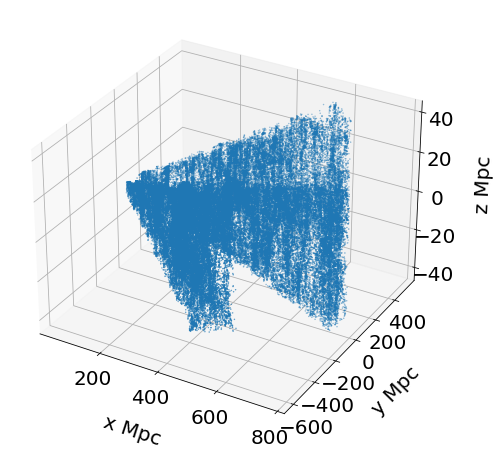

In [4]:
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.scatter3D(pos[:,0], pos[:,1], pos[:,2], s=0.2)
ax.set_xlabel('x Mpc')
ax.set_ylabel('y Mpc')
ax.set_zlabel('z Mpc')
pl.show()

In [5]:
G15 = np.array(data['FIELD'], dtype=str)
ii_G15 = G15 == 'G15'
ii_G15

array([False, False,  True, ..., False,  True, False])

In [6]:
DDP = np.array(data['DDP'])
ii_DDP1 = DDP[:,0] == 1 
df_pos_DDP1 = pos[ii_DDP1 & ii_G15]
pos = pos[ii_DDP1 & ii_G15]

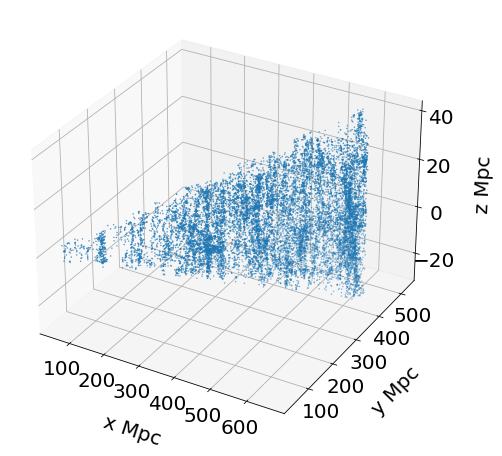

In [7]:
fig = pl.figure(figsize=(8,8), rasterized=True)
ax = pl.axes(projection='3d')
ax.set_xlabel('x Mpc')
ax.set_ylabel('y Mpc')
ax.set_zlabel('z Mpc')
ax.scatter3D(pos[:,0], pos[:,1], pos[:,2], s=0.2)

In [8]:
kd_tree_gama = KDTree(pos)
indexes_gama = kd_tree_gama.query_ball_tree(kd_tree_gama, r=8)

In [9]:
kdtree_gama = np.array([ np.array([np.array(i), len(i)], dtype=object)  for i in indexes_gama])

Text(0.5, 0, 'Number of connections')

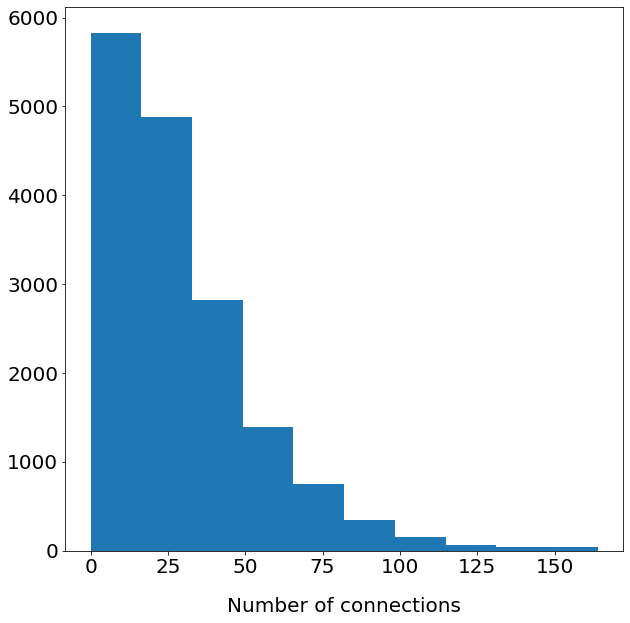

In [10]:
_ = pl.hist(kdtree_gama[:,1]-1)
pl.xlabel('Number of connections')

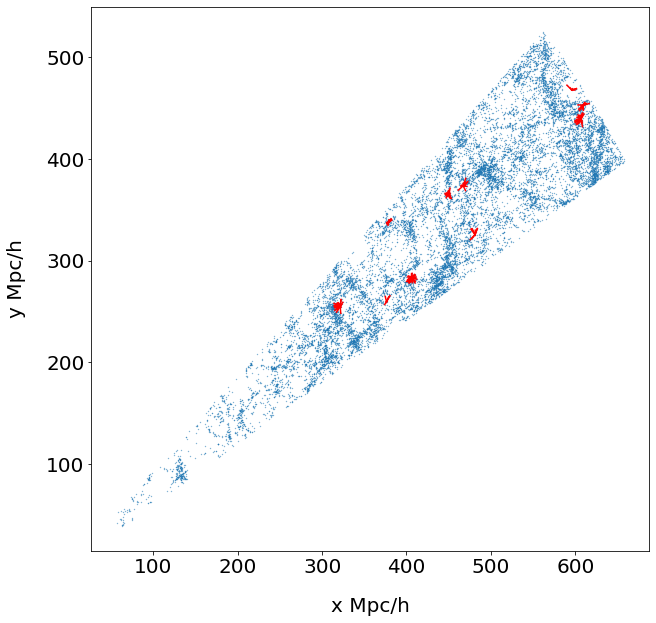

In [11]:
pl.scatter(pos[:,0], pos[:,1], s= 0.1, alpha=0.8)
for i in range(len(indexes_gama[:10])):
    for j in indexes_gama[i]:
        pl.plot([pos[i,0], pos[j,0]],[pos[i,1], pos[j,1]], "-r")
pl.ylabel('y Mpc/h')        
pl.xlabel('x Mpc/h')
pl.show()

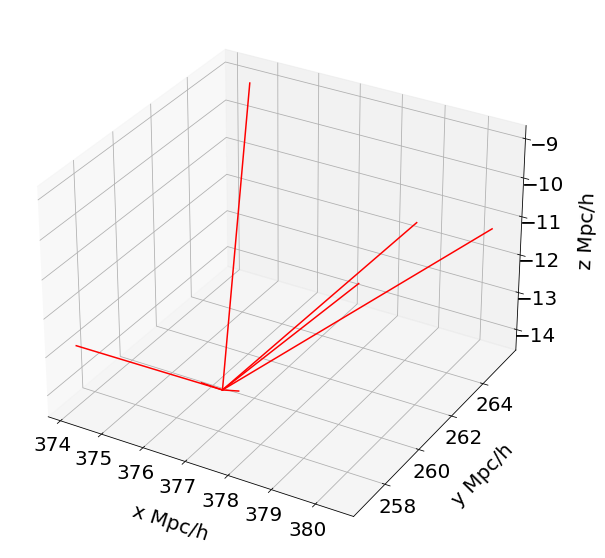

In [12]:
fig = pl.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(indexes_gama[:1])):
    for j in indexes_gama[i]:
        pl.plot([pos[i,0], pos[j,0]],[pos[i,1], pos[j,1]],[pos[i,2], pos[j,2]], "-r")
ax.set_zlabel('z Mpc/h')
ax.set_ylabel('y Mpc/h')
ax.set_xlabel('x Mpc/h')
pl.show()

### Tidal Tensor

In [13]:
# ngrid = 256
# Lbox = 600 #?
# print(Lbox)

# cellsize = Lbox / ngrid #?
# print(cellsize)

# volume = Lbox ** 3 #(?)^3
# print(volume)

# meandensity = len(pos) / volume
# print(meandensity)

# density, bins = np.histogramdd(pos, bins=ngrid, range=None, normed=None, weights=None, density=None)
# print(density.shape)

# deltas = (density / meandensity) - 1.
# print(np.shape(deltas))

In [14]:
# def Wg(k2, R):
#     return np.exp(-k2*R*R/2.)

# def get_fourier_smooth(density,R_smooth,N_dim,Lbox):
#     karr = np.fft.fftfreq(N_dim, d=Lbox/(2*np.pi*N_dim))
#     d_four = np.fft.fftn(density)
#     del density
    
#     #dksmo = np.zeros(shape=(N_dim, N_dim, N_dim),dtype=complex)
#     ksq = np.zeros(shape=(N_dim, N_dim, N_dim),dtype=complex)
#     ksq[:,:,:] = karr[None,None,:]**2+karr[None,:,None]**2+karr[:,None,None]**2
#     d_four[:,:,:] = Wg(ksq,R_smooth)*d_four

#     return karr, ksq, d_four

# @jit(nopython=True)
# def get_tidal_field(dfour,karr,N_dim):
#     tfour = np.zeros(shape=(N_dim, N_dim, N_dim, 3, 3), dtype=nb.complex128)
    
#     # computing tidal tensor and phi in fourier space
#     # and smoothing using the window functions
#     for a in range(N_dim):
#         for b in range(N_dim):
#             for c in range(N_dim):
#                 if (a, b, c) == (0, 0, 0):
#                     pass
#                 else:
#                     ksq = karr[a]**2 + karr[b]**2 + karr[c]**2
#                     # all 9 components
#                     tfour[a, b, c, 0, 0] = karr[a]*karr[a]*dfour[a, b, c]/ksq
#                     tfour[a, b, c, 1, 1] = karr[b]*karr[b]*dfour[a, b, c]/ksq
#                     tfour[a, b, c, 2, 2] = karr[c]*karr[c]*dfour[a, b, c]/ksq
#                     tfour[a, b, c, 1, 0] = karr[a]*karr[b]*dfour[a, b, c]/ksq
#                     tfour[a, b, c, 0, 1] = tfour[a, b, c, 1, 0]
#                     tfour[a, b, c, 2, 0] = karr[a]*karr[c]*dfour[a, b, c]/ksq
#                     tfour[a, b, c, 0, 2] = tfour[a, b, c, 2, 0]
#                     tfour[a, b, c, 1, 2] = karr[b]*karr[c]*dfour[a, b, c]/ksq
#                     tfour[a, b, c, 2, 1] = tfour[a, b, c, 1, 2]

#     return tfour

# def get_eig(tidt, N_dim):
#     evals = np.zeros(shape=(N_dim, N_dim, N_dim, 3))

#     for x in range(N_dim):
#         for y in range(N_dim):
#             for z in range(N_dim):
#                 # comute and sort evalues in ascending order, for descending add after argsort()[::-1]
#                 evals[x, y, z, :], evects = la.eig(tidt[x, y, z, :, :])
#                 idx = evals[x, y, z, :].argsort()
#                 evals[x, y, z] = evals[x, y, z, idx]
#                 #evects = evects[:, idx]
    
#     lambda1 = evals[:,:,:,0]
#     lambda2 = evals[:,:,:,1]
#     lambda3 = evals[:,:,:,2]

#     return lambda1, lambda2, lambda3

In [15]:
# karr, ksd, d_four = get_fourier_smooth(deltas, R_smooth=8., N_dim=ngrid, Lbox=Lbox)

In [16]:
# tidal_tilde = get_tidal_field(d_four, karr, ngrid)

In [17]:
# tidal_real = np.zeros(shape=(ngrid, ngrid, ngrid, 3, 3),dtype=float) # Normalized by 4. * np.pi * 6.6743e-11

In [18]:
# for i in range(3):
#     for j in range(3):
#         tidal_real[:,:,:,i,j] = np.real(np.fft.ifftn(tidal_tilde[:,:,:,i,j]))

In [19]:
# lambda1, lambda2, lambda3 = get_eig(tidal_real, ngrid)

In [20]:
# lth = 0.2/200

# _ = pl.hist(lambda1.flatten(), histtype='step', bins=100, label='lamba_1')
# _ = pl.hist(lambda2.flatten(), histtype='step', bins=100, label='lamba_2')
# _ = pl.hist(lambda3.flatten(), histtype='step', bins=100, label='lamba_3')

# pl.axvline(lth, c='k', lw=0.5)
# pl.legend()

In [21]:
# ii_box = (pos[:,0]//cellsize).astype(int)
# jj_box = (pos[:,1]//cellsize).astype(int)
# kk_box = (pos[:,2]//cellsize).astype(int)

# lambda1_halo = lambda1[ii_box, jj_box, kk_box]
# lambda2_halo = lambda2[ii_box, jj_box, kk_box]
# lambda3_halo = lambda3[ii_box, jj_box, kk_box]
# delta_halo = deltas[ii_box, jj_box, kk_box]

In [22]:
# environment = np.zeros(len(pos), dtype=int)

# # Attached the environment to the galaxies
# ii_void = (lambda1_halo < lth) & (lambda2_halo < lth) & (lambda3_halo < lth)
# ii_sheet = (lambda3_halo > lth) & (lambda2_halo < lth) & (lambda1_halo < lth)
# ii_filament = (lambda3_halo > lth) & (lambda2_halo > lth) & (lambda1_halo < lth)
# ii_peak = (lambda1_halo > lth) & (lambda2_halo > lth) & (lambda3_halo > lth)
# environment[ii_void] = 3
# environment[ii_sheet] = 2        
# environment[ii_filament] = 1        
# environment[ii_peak] = 0

In [23]:
# is_slice = (pos[:,2] < 100.)  &   (pos[:,2] > 80.) #Mpc
# is_void     = environment == 3
# is_sheet    = environment == 2
# is_filament = environment == 1
# is_peak     = environment == 0

# fig = pl.figure(figsize=(8,8))
# pl.subplot(2,2,1)
# pl.scatter(pos[:,0][is_void & is_slice] , pos[:,1][is_void & is_slice], s=5, c='k')
# pl.xlabel('x Mpc/h')
# pl.ylabel('y Mpc/h')
# pl.title('Voids')
# pl.subplot(2,2,2)
# pl.scatter(pos[:,0][is_sheet & is_slice] , pos[:,1][is_sheet & is_slice], s=5, c='g')
# pl.title('Sheets')
# pl.xlabel('x Mpc/h')
# pl.ylabel('y Mpc/h')
# pl.subplot(2,2,3)
# pl.scatter(pos[:,0][is_filament & is_slice] , pos[:,1][is_filament & is_slice], s=5, c='orange')
# pl.title('Filaments')
# pl.xlabel('x Mpc/h')
# pl.ylabel('y Mpc/h')
# pl.subplot(2,2,4)
# pl.scatter(pos[:,0][is_peak & is_slice] , pos[:,1][is_peak & is_slice], s=5, c='r')
# pl.title('Peaks')
# pl.xlabel('x Mpc/h')
# pl.ylabel('y Mpc/h')
# pl.tight_layout()
# pl.show()

# fig = pl.figure(figsize=(8,8))
# pl.scatter(pos[:,0][is_void & is_slice] , pos[:,1][is_void & is_slice], s=5, c='k')
# pl.scatter(pos[:,0][is_sheet & is_slice] , pos[:,1][is_sheet & is_slice], s=5, c='g')
# pl.scatter(pos[:,0][is_filament & is_slice] , pos[:,1][is_filament & is_slice], s=5, c='orange')
# pl.scatter(pos[:,0][is_peak & is_slice] , pos[:,1][is_peak & is_slice], s=5, c='r')
# pl.xlabel('x Mpc/h')
# pl.ylabel('y Mpc/h')
# pl.show()

In [24]:
# _ = pl.hist(delta_halo)

## Magnitudes

In [25]:
magnitudes_labels = ['UMAG_DRED_SDSS','GMAG_DRED_SDSS','RMAG_DRED_SDSS','IMAG_DRED_SDSS','ZMAG_DRED_SDSS']
magnitudes = data[magnitudes_labels].to_pandas()[ii_DDP1 & ii_G15]

In [26]:
magnitudes

,UMAG_DRED_SDSS,GMAG_DRED_SDSS,RMAG_DRED_SDSS,IMAG_DRED_SDSS,ZMAG_DRED_SDSS
10,21.292801,19.692480,18.628998,18.124001,17.606222
24,21.247129,20.350700,19.465240,19.110510,18.702700
30,20.280121,19.244968,18.567120,18.197523,18.095039
31,20.709352,19.154469,18.260920,17.886192,17.556767
53,20.339539,19.494122,18.847221,18.469799,18.331257
...,...,...,...,...,...
121914,19.613569,18.652378,18.155947,17.814310,17.667555
121929,19.367895,17.734371,17.127880,16.866352,16.696077
121933,20.651821,19.292326,18.358288,17.906256,17.583710
121954,23.042261,20.298552,18.932289,18.435946,18.094007


In [27]:
Mg_Mr = magnitudes['GMAG_DRED_SDSS']-magnitudes['RMAG_DRED_SDSS']
ii_blue = Mg_Mr <0.6
sum(ii_blue), sum(~ii_blue)

(1146, 15172)

In [28]:
galaxy_class =  np.zeros(len(Mg_Mr))
galaxy_class[ii_blue] = 0
galaxy_class[~ii_blue] = 1

In [29]:
df = pd.DataFrame(  np.c_[indexes_gama, magnitudes, galaxy_class], columns=['connections','umag','gmag','rmag','imag','zmag','galaxy_class']  )
df.to_pickle('./data/GAMA_dataset.pkl')

/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/numpy/lib/index_tricks.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newobj = array(item, copy=False, subok=True, ndmin=ndmin)


In [30]:
df_temp = pd.read_pickle('./data/GAMA_dataset.pkl')

In [31]:
df_temp

,connections,umag,gmag,rmag,imag,zmag,galaxy_class
0,"[0, 92, 2310, 2312, 5822, 9634, 15253, 15709]",21.292801,19.69248,18.628998,18.124001,17.606222,1.0
1,"[1, 928, 4123, 4279, 4392, 4452, 6107, 7394, 7...",21.247129,20.3507,19.46524,19.11051,18.7027,1.0
2,"[2, 1080, 1494, 1613, 2422, 3293, 4223, 5467, ...",20.280121,19.244968,18.56712,18.197523,18.095039,1.0
3,"[3, 410, 698, 975, 997, 1224, 1422, 2335, 2932...",20.709352,19.154469,18.26092,17.886192,17.556767,1.0
4,"[4, 257, 2793, 5403, 6225, 6783, 8238, 9430, 9...",20.339539,19.494122,18.847221,18.469799,18.331257,1.0
...,...,...,...,...,...,...,...
16313,"[235, 4046, 5301, 6051, 6656, 7563, 9563, 1037...",19.613569,18.652378,18.155947,17.81431,17.667555,0.0
16314,"[352, 813, 2233, 3016, 3878, 4333, 4455, 6276,...",19.367895,17.734371,17.12788,16.866352,16.696077,1.0
16315,"[193, 217, 322, 1663, 1927, 2065, 2432, 2892, ...",20.651821,19.292326,18.358288,17.906256,17.58371,1.0
16316,"[440, 637, 1141, 1408, 1429, 2870, 3018, 3136,...",23.042261,20.298552,18.932289,18.435946,18.094007,1.0
